In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
root = os.getcwd()
parent = os.path.join(root, 'data', 'rain')
filename = os.listdir(parent)[0]
file_path = os.path.join(parent, filename)

In [131]:
df = pd.read_csv(file_path)
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df = df[df.Date.dt.year>=2009]
df = df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1)

In [132]:
df2 = df.sort_values(by=['Location', 'Date']).groupby(by=['Location']).fillna(axis=0, method='ffill')\
            .fillna(axis=0, method='bfill')
df = df2.join(df['Location'], how='left')

In [144]:
df['temp_day_range'] = df['MaxTemp']-df['MinTemp']

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143129 entries, 96504 to 108570
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           143129 non-null  datetime64[ns]
 1   MinTemp        143129 non-null  float64       
 2   MaxTemp        143129 non-null  float64       
 3   Rainfall       143129 non-null  float64       
 4   WindGustDir    143129 non-null  object        
 5   WindGustSpeed  143129 non-null  float64       
 6   WindDir9am     143129 non-null  object        
 7   WindDir3pm     143129 non-null  object        
 8   WindSpeed9am   143129 non-null  float64       
 9   WindSpeed3pm   143129 non-null  float64       
 10  Humidity9am    143129 non-null  float64       
 11  Humidity3pm    143129 non-null  float64       
 12  Pressure9am    143129 non-null  float64       
 13  Pressure3pm    143129 non-null  float64       
 14  Temp9am        143129 non-null  float64       
 

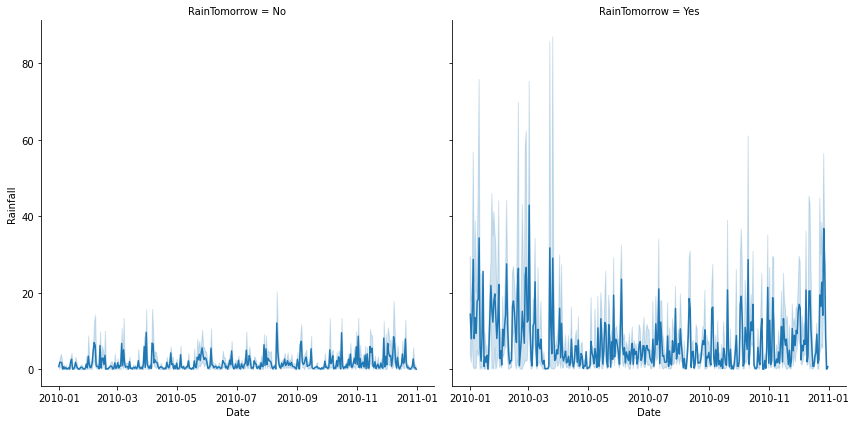

In [150]:
g = sns.relplot(data=df[df.Date.dt.year==2010]
            , x='Date', y='Rainfall'
            , col='RainTomorrow'#, hue='Location'
            , kind='line'
            , height=6, aspect=1
           )

In [1]:
# sns.pairplot(data=df.sample(1000)
#              , diag_kind='kde'
#              , hue='RainToday'
#             )

In [147]:
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

### Plan of action to pre-process the data

1. Target variable for this data set is the RainTomorrow variable
2. There are complications here since the data is time series data, there could e strong autocorrelations in the data
3. Also given that there are locations in the data set there could also be stron spatial correlations that we need to watch out for
4. Want to test the data for auto-correlation using the Adj. Dickey-Fuller test (ADF)
5. Train test split. Given the data is imbalanced interms of the labels, sugegst to do a startified sampling bsed on label set
6. Need to draw out the pre-processing pipeline:
    a. Missing values ffill and bfill. Try median imputation as well and check the statistics using describe 
    b. Add the derived variable: Temp range
    c. Scale (Standardize/Normalize) the numerical variable
    d. Check if any of the variables can be discretized
7. Have a bunch of candidate models for the task
8. Use cross validation for model selection and hyper-parameter tuning (Grid/Randomized search CV)
9. Evaluate Generalization error
10.Monitor the performance of the model
11. CHeck if the live data is available on teh Australian website to download


In [2]:
import sklearn as sk